# Machine Learning Practical: Coursework 1

**Release date: Monday 10th October 2016**  
**Due date: 16:00 Thursday 27th October 2016**

Instructions for the coursework are [available as a PDF here](http://www.inf.ed.ac.uk/teaching/courses/mlp/2016/coursework_1.pdf).

# Georgios Pligoropoulos - s1687568

In [4]:
%load_ext autoreload

%autoreload 0

In [5]:
import sys
mlpdir = '/home/student/Dropbox/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical'
sys.path.append(mlpdir)

In [6]:
#more imports
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline
from mlp.optimisers import Optimiser
import numpy as np
from mlp.learning_rules import GradientDescentLearningRule, MomentumLearningRule, \
    AdaGradLearningRule, RmsPropLearningRule
from mlp.schedulers import MomentumCoefficientScheduler, ConstantLearningRateScheduler,\
    ReciprocalLearningRateScheduler, ExponentialLearningRateScheduler

In [7]:
def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers=[]):

    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors, schedulers = schedulers)

    # Run the optimiser for some number of epochs (full passes through the training set)
    # printing statistics every epoch
    stats, keys, runTime = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    
    return stats, keys, fig_1, ax_1, fig_2, ax_2, runTime

In [8]:
def getFinalValues(statistics):
    lastStats = statistics[-1]
    return {
        "finalTrainingError": lastStats[0],
        "finalTrainingAccuracy": lastStats[1],
        "finalTestingError": lastStats[2],
        "finalTestingAccuracy": lastStats[3],
    }

In [9]:
num_epochs = 100
stats_interval = 5

In [18]:
#Let's visualize the two time dependent learning rate schedules to see how they look like
def plotExponentialLearningRate(n0, r):
    fig = plt.figure()
    t = np.arange(0, 100, 0.1)
    f = n0 * np.exp(-t/r)
    plt.plot(t, f, 'b-') #bo, b+ etc.
    #plt.axis([0, 6, 0, 20])
    plt.xlabel('epochs')
    plt.ylabel('learning rate value')
    plt.show()
    return fig
    
def plotReciprocalLearningRate(n0, r):
    fig = plt.figure()
    t = np.arange(0, 100, 0.1)
    #f = n0 * ((1 + t/r)**(-1))
    f = n0 / (1 + t/r)
    plt.plot(t, f, 'b-') #bo, b+ etc.
    #plt.axis([0, 6, 0, 20])
    plt.xlabel('epochs')
    plt.ylabel('learning rate value')
    plt.show()
    return fig

## Part 1: Learning rate schedules

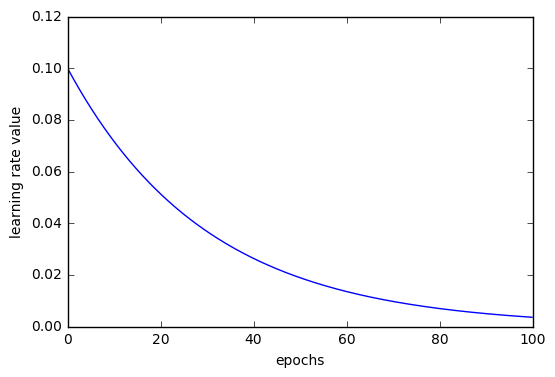

In [19]:
fig = plotExponentialLearningRate(0.1, 30) #in this example this decays more linearly at the beginning
#fig.savefig('constant1_lr_0.1.svg')

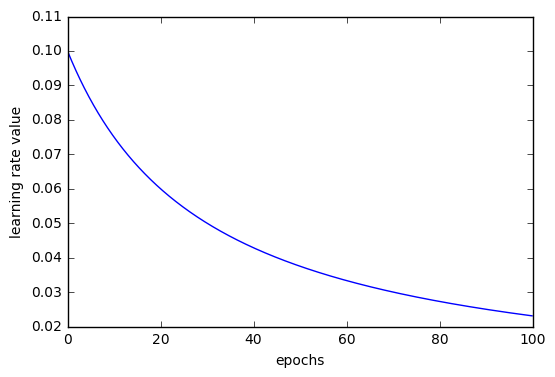

In [20]:
fig = plotReciprocalLearningRate(0.1, 30) #in this example this is steeper at first

In [10]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider

# Seed a random number generator
seed = 10102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

In [11]:
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit

input_dim, output_dim, hidden_dim = 784, 10, 100

In [12]:
from mlp.schedulers import MomentumCoefficientScheduler, ConstantLearningRateScheduler, ReciprocalLearningRateScheduler, ExponentialLearningRateScheduler

In [13]:
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

def resetting():
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
        SigmoidLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
        SigmoidLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ])
    
    error = CrossEntropySoftmaxError()

    return model, error

### Constant Learning Rate 0.1

Epoch 5: 3.03s to complete
    error(train)=2.52e-01, acc(train)=9.27e-01, error(valid)=2.39e-01, acc(valid)=9.29e-01
Epoch 10: 3.34s to complete
    error(train)=1.71e-01, acc(train)=9.51e-01, error(valid)=1.70e-01, acc(valid)=9.53e-01
Epoch 15: 3.31s to complete
    error(train)=1.25e-01, acc(train)=9.64e-01, error(valid)=1.36e-01, acc(valid)=9.63e-01
Epoch 20: 3.64s to complete
    error(train)=9.79e-02, acc(train)=9.73e-01, error(valid)=1.18e-01, acc(valid)=9.66e-01
Epoch 25: 3.78s to complete
    error(train)=7.76e-02, acc(train)=9.79e-01, error(valid)=1.05e-01, acc(valid)=9.71e-01
Epoch 30: 3.70s to complete
    error(train)=6.34e-02, acc(train)=9.83e-01, error(valid)=9.76e-02, acc(valid)=9.71e-01
Epoch 35: 3.36s to complete
    error(train)=5.32e-02, acc(train)=9.86e-01, error(valid)=9.61e-02, acc(valid)=9.73e-01
Epoch 40: 2.97s to complete
    error(train)=4.23e-02, acc(train)=9.90e-01, error(valid)=8.87e-02, acc(valid)=9.75e-01
Epoch 45: 3.00s to complete
    error(train)=3.41

{'finalTestingAccuracy': 0.97719999999999896,
 'finalTestingError': 0.087702536615739582,
 'finalTrainingAccuracy': 0.99972000000000028,
 'finalTrainingError': 0.0057680421129708403}

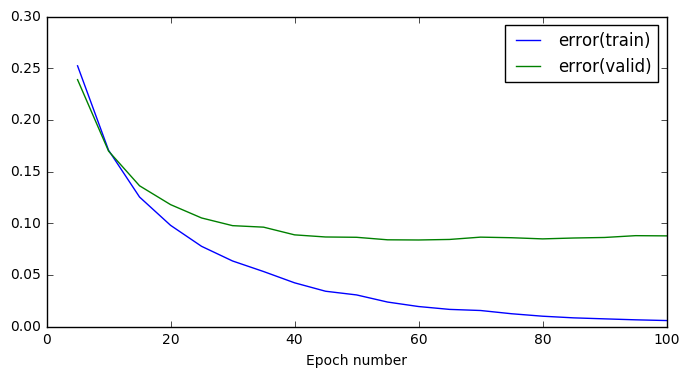

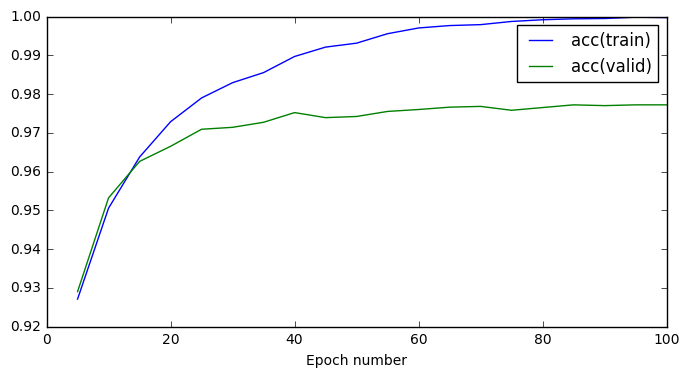

In [14]:
model, error = resetting()

learningRate = 0.1
learning_rule = GradientDescentLearningRule(learning_rate=learningRate)

#stats, keys, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
stats, keys, fig_1, ax_1, fig_2, ax_2, runTime = train_model_and_plot_stats(
    model, error, 
    learning_rule,
    train_data, valid_data, num_epochs, stats_interval,
    schedulers = [ConstantLearningRateScheduler(learningRate)]
)

fig_1.savefig('constant1_lr_0.1.svg')
fig_2.savefig('constant2_lr_0.1.svg')

getFinalValues(stats)

### Constant Learning rate more than ten times bigger 1.1

Epoch 5: 1.21s to complete
    error(train)=5.98e-02, acc(train)=9.82e-01, error(valid)=9.55e-02, acc(valid)=9.72e-01
Epoch 10: 1.13s to complete
    error(train)=1.99e-02, acc(train)=9.95e-01, error(valid)=9.11e-02, acc(valid)=9.75e-01
Epoch 15: 1.84s to complete
    error(train)=6.11e-03, acc(train)=9.99e-01, error(valid)=8.80e-02, acc(valid)=9.78e-01
Epoch 20: 1.12s to complete
    error(train)=1.64e-03, acc(train)=1.00e+00, error(valid)=9.11e-02, acc(valid)=9.79e-01
Epoch 25: 1.51s to complete
    error(train)=9.47e-04, acc(train)=1.00e+00, error(valid)=9.36e-02, acc(valid)=9.79e-01
Epoch 30: 1.40s to complete
    error(train)=6.48e-04, acc(train)=1.00e+00, error(valid)=9.62e-02, acc(valid)=9.79e-01
Epoch 35: 1.21s to complete
    error(train)=5.09e-04, acc(train)=1.00e+00, error(valid)=9.89e-02, acc(valid)=9.79e-01
Epoch 40: 1.30s to complete
    error(train)=4.16e-04, acc(train)=1.00e+00, error(valid)=1.00e-01, acc(valid)=9.79e-01
Epoch 45: 1.95s to complete
    error(train)=3.51

{'finalTestingAccuracy': 0.97979999999999945,
 'finalTestingError': 0.11143797342816182,
 'finalTrainingAccuracy': 1.0,
 'finalTrainingError': 0.0001197176774069035}

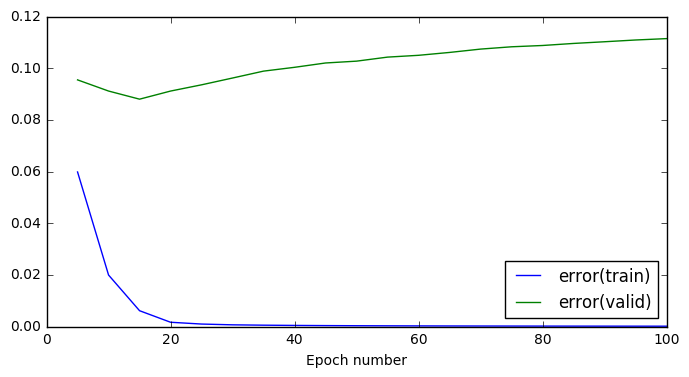

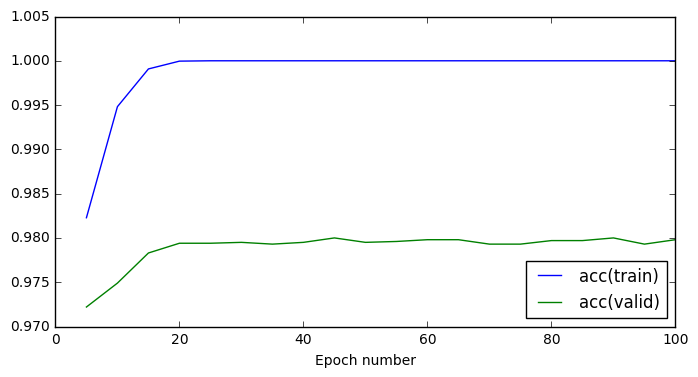

In [14]:
model, error = resetting()

learning_rate = 1.1
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

#stats, keys, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
stats, keys, fig_1, ax_1, fig_2, ax_2, runTime = train_model_and_plot_stats(
    model, error, 
    learning_rule,
    train_data, valid_data, num_epochs, stats_interval,
    schedulers = [ConstantLearningRateScheduler(learning_rate)]
)

fig_1.savefig('constant1_lr_1.1.svg')
fig_2.savefig('constant2_lr_1.1.svg')

getFinalValues(stats)

Here we probably have some kind of overfitting because the training error has reached zero while the accuracy is equal to 100%.

While on the testing (validation) data we have the final testing error being much smaller than before which is a good thing. This means that we didn't overfit too much. The accuracy is around 98% percent

### Reciprocal Learning Rate with n0 = 1e-1 and r = 1

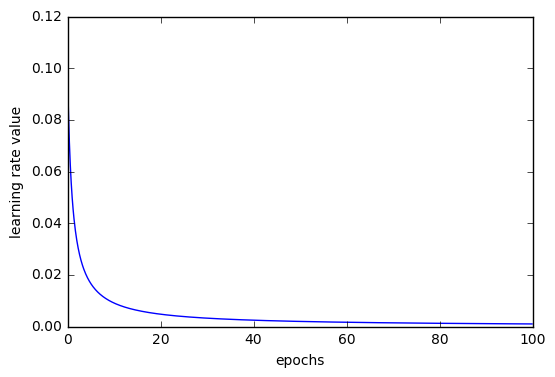

In [22]:
learningRate = 1e-1
r = 1

fig = plotReciprocalLearningRate(learningRate, r) #in this example this is steeper at first
fig.savefig('reciprocalFunction_lr_0.1_r_1.svg')

Epoch 5: 1.12s to complete
    error(train)=3.51e-01, acc(train)=9.00e-01, error(valid)=3.25e-01, acc(valid)=9.08e-01
Epoch 10: 1.13s to complete
    error(train)=3.17e-01, acc(train)=9.09e-01, error(valid)=2.94e-01, acc(valid)=9.16e-01
Epoch 15: 1.21s to complete
    error(train)=3.02e-01, acc(train)=9.13e-01, error(valid)=2.81e-01, acc(valid)=9.20e-01
Epoch 20: 1.16s to complete
    error(train)=2.92e-01, acc(train)=9.16e-01, error(valid)=2.72e-01, acc(valid)=9.21e-01
Epoch 25: 1.21s to complete
    error(train)=2.85e-01, acc(train)=9.17e-01, error(valid)=2.67e-01, acc(valid)=9.23e-01
Epoch 30: 1.13s to complete
    error(train)=2.80e-01, acc(train)=9.19e-01, error(valid)=2.62e-01, acc(valid)=9.25e-01
Epoch 35: 1.23s to complete
    error(train)=2.76e-01, acc(train)=9.20e-01, error(valid)=2.58e-01, acc(valid)=9.25e-01
Epoch 40: 1.12s to complete
    error(train)=2.72e-01, acc(train)=9.21e-01, error(valid)=2.55e-01, acc(valid)=9.26e-01
Epoch 45: 1.17s to complete
    error(train)=2.69

{'finalTestingAccuracy': 0.93079999999999918,
 'finalTestingError': 0.23579235857041062,
 'finalTrainingAccuracy': 0.9268800000000027,
 'finalTrainingError': 0.24976117327795377}

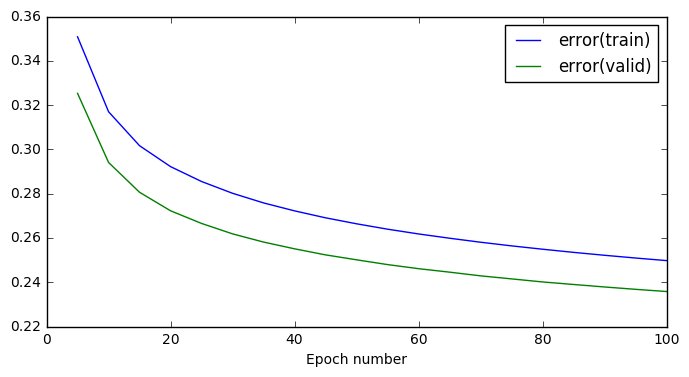

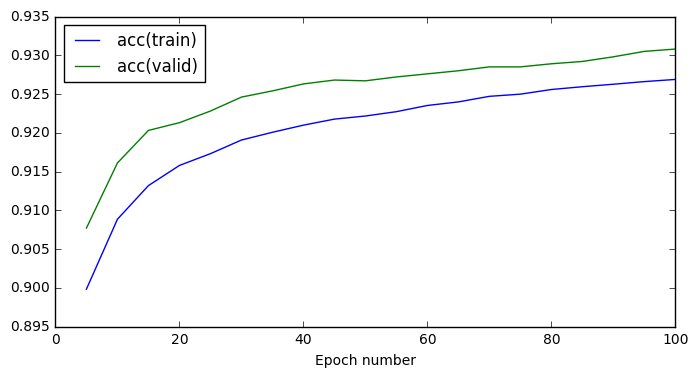

In [17]:
model, error = resetting()

#this is only the initial learning rate, the scheduler updates the learning rate within the loop
learning_rule = GradientDescentLearningRule(learning_rate=learningRate)

#stats, keys, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
stats, keys, fig_1, ax_1, fig_2, ax_2, runTime = train_model_and_plot_stats(
    model, error, 
    learning_rule,
    train_data, valid_data, num_epochs, stats_interval,
    schedulers = [ReciprocalLearningRateScheduler(learning_rate=learningRate, r = r)]
)

fig_1.savefig('reciprocal1_lr_0.1_r_1.svg')
fig_2.savefig('reciprocal2_lr_0.1_r_1.svg')

getFinalValues(stats)

Here we have a very fast learning at the beginning and then no real progress or very slow learning.

### Reciprocal Learning Rate with n0 = 0.1 and r = 50

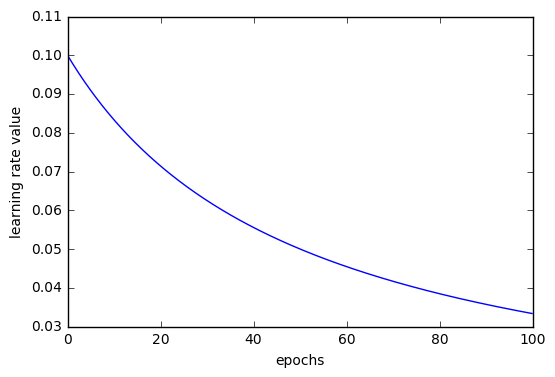

In [25]:
learningRate = 1e-1
r = 50 #similar to batch

fig = plotReciprocalLearningRate(learningRate, r) #in this example this is steeper at first
fig.savefig('reciprocalFunction_n0_0.1_r50.svg')

Epoch 5: 1.13s to complete
    error(train)=2.57e-01, acc(train)=9.26e-01, error(valid)=2.40e-01, acc(valid)=9.30e-01
Epoch 10: 1.33s to complete
    error(train)=1.73e-01, acc(train)=9.50e-01, error(valid)=1.71e-01, acc(valid)=9.53e-01
Epoch 15: 1.22s to complete
    error(train)=1.23e-01, acc(train)=9.64e-01, error(valid)=1.31e-01, acc(valid)=9.63e-01
Epoch 20: 1.15s to complete
    error(train)=9.63e-02, acc(train)=9.73e-01, error(valid)=1.13e-01, acc(valid)=9.68e-01
Epoch 25: 1.27s to complete
    error(train)=7.48e-02, acc(train)=9.80e-01, error(valid)=1.01e-01, acc(valid)=9.71e-01
Epoch 30: 1.20s to complete
    error(train)=5.95e-02, acc(train)=9.84e-01, error(valid)=9.45e-02, acc(valid)=9.74e-01
Epoch 35: 1.21s to complete
    error(train)=5.00e-02, acc(train)=9.87e-01, error(valid)=9.15e-02, acc(valid)=9.74e-01
Epoch 40: 1.13s to complete
    error(train)=4.19e-02, acc(train)=9.90e-01, error(valid)=8.72e-02, acc(valid)=9.75e-01
Epoch 45: 1.13s to complete
    error(train)=3.50

{'finalTestingAccuracy': 0.9778999999999991,
 'finalTestingError': 0.08500421136775857,
 'finalTrainingAccuracy': 0.99990000000000012,
 'finalTrainingError': 0.0051582503349232763}

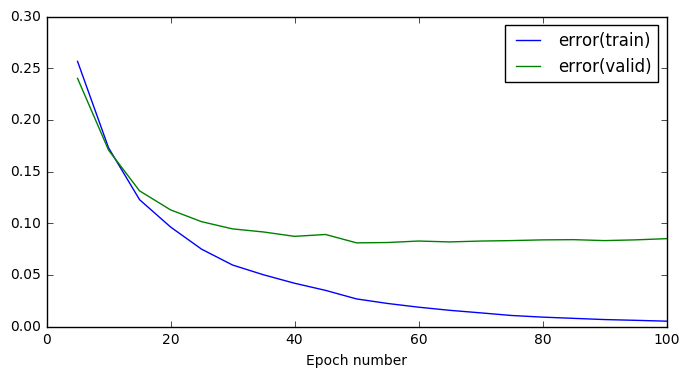

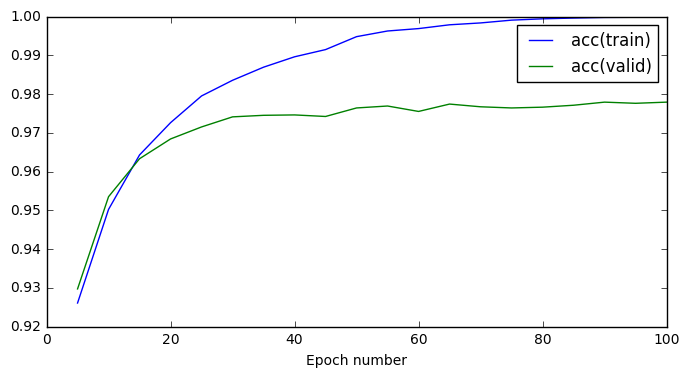

In [20]:
model, error = resetting()

#this is only the initial learning rate, the scheduler updates the learning rate within the loop
learning_rule = GradientDescentLearningRule(learning_rate=learningRate)

#stats, keys, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
stats, keys, fig_1, ax_1, fig_2, ax_2, runTime = train_model_and_plot_stats(
    model, error, 
    learning_rule,
    train_data, valid_data, num_epochs, stats_interval,
    #schedulers = [ReciprocalLearningRateScheduler(learning_rate=learningRate, r = r)]
    schedulers = [ConstantLearningRateScheduler(learning_rate=learningRate)]
)

fig_1.savefig('reciprocal1_lr_0.2_r_50.svg')
fig_2.savefig('reciprocal2_lr_0.2_r_50.svg')

getFinalValues(stats)

In this experiment we see that we reach at training accuracy near to perfect so we might have slightly overfitted but in general we have achieved a better final accuracy and good error for the validation set because we have left the learning rate do its job. We also see that the training error and training accuracy manages to surpass the validation accuracy and validation error which did not happen in the previous experiment because of the very slow learning rate. The final convergence is acceptable but we must note that we nees at least 50 epochs to reach near there and then the progress is slow.

### Reciprocal Learning Rate n0 = 0.1 r = 1000

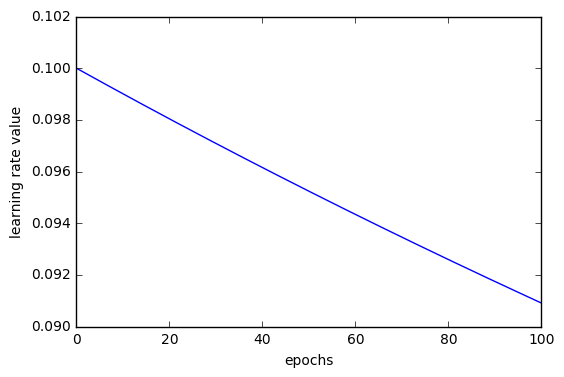

In [24]:
learningRate = 1e-1
r = 1000 #similar to batch

fig = plotReciprocalLearningRate(learningRate, r) #in this example this is almost flatline
fig.savefig('reciprocalFunction_n0_0.1_r_1000.svg')

Epoch 5: 1.25s to complete
    error(train)=2.59e-01, acc(train)=9.24e-01, error(valid)=2.44e-01, acc(valid)=9.29e-01
Epoch 10: 1.20s to complete
    error(train)=1.79e-01, acc(train)=9.47e-01, error(valid)=1.76e-01, acc(valid)=9.51e-01
Epoch 15: 1.14s to complete
    error(train)=1.29e-01, acc(train)=9.62e-01, error(valid)=1.38e-01, acc(valid)=9.62e-01
Epoch 20: 1.23s to complete
    error(train)=9.90e-02, acc(train)=9.72e-01, error(valid)=1.19e-01, acc(valid)=9.67e-01
Epoch 25: 1.23s to complete
    error(train)=7.71e-02, acc(train)=9.79e-01, error(valid)=1.05e-01, acc(valid)=9.71e-01
Epoch 30: 1.64s to complete
    error(train)=6.27e-02, acc(train)=9.83e-01, error(valid)=9.88e-02, acc(valid)=9.71e-01
Epoch 35: 1.47s to complete
    error(train)=5.04e-02, acc(train)=9.86e-01, error(valid)=9.41e-02, acc(valid)=9.73e-01
Epoch 40: 1.26s to complete
    error(train)=4.07e-02, acc(train)=9.90e-01, error(valid)=8.88e-02, acc(valid)=9.75e-01
Epoch 45: 1.39s to complete
    error(train)=3.34

{'finalTestingAccuracy': 0.97709999999999897,
 'finalTestingError': 0.089878672016525621,
 'finalTrainingAccuracy': 0.99984000000000017,
 'finalTrainingError': 0.0055747042040339388}

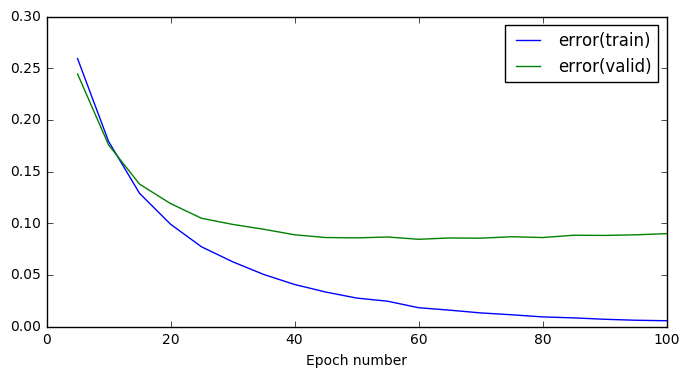

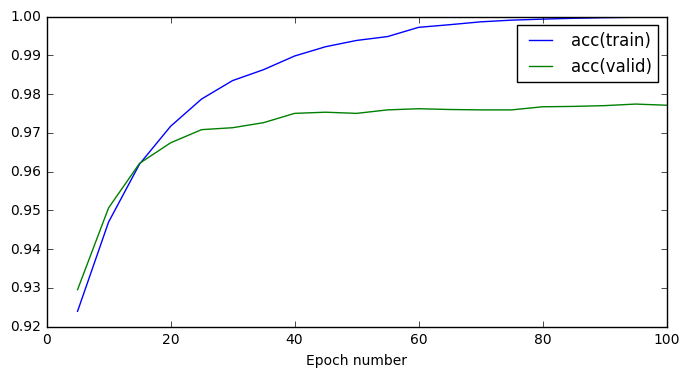

In [23]:
model, error = resetting()

#this is only the initial learning rate, the scheduler updates the learning rate within the loop
learning_rule = GradientDescentLearningRule(learning_rate=learningRate)

#stats, keys, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
stats, keys, fig_1, ax_1, fig_2, ax_2, runTime = train_model_and_plot_stats(
    model, error, 
    learning_rule,
    train_data, valid_data, num_epochs, stats_interval,
    schedulers = [ReciprocalLearningRateScheduler(learning_rate=learningRate, r = r)]
    #schedulers = [ConstantLearningRateScheduler(learning_rate=learningRate)]
)

fig_1.savefig('reciprocal1_lr_0.1_r_1000.svg')
fig_2.savefig('reciprocal2_lr_0.1_r_1000.svg')

getFinalValues(stats)

Here we have a better combination of values because we see that the neural network is able to learn very fast and afterwards by lowering the learning rate we help to make it converge to a final state. The drawback is of course that we cannot be sure that we have not fallen into any local minima.

## Part 2: Momentum learning rule

In [24]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider

# Seed a random number generator
seed = 10102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

In [25]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit

input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# we are calling them by reset
# model = MultipleLayerModel([
#     AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
#     SigmoidLayer(),
#     AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
#     SigmoidLayer(),
#     AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
# ])

# error = CrossEntropySoftmaxError()

### Mom Coefficient 0.1 (having mom coefficient to zero fallbacks to our original case)

Epoch 5: 1.44s to complete
    error(train)=2.24e+00, acc(train)=2.97e-01, error(valid)=2.24e+00, acc(valid)=2.98e-01
Epoch 10: 1.47s to complete
    error(train)=2.16e+00, acc(train)=4.54e-01, error(valid)=2.16e+00, acc(valid)=4.66e-01
Epoch 15: 1.29s to complete
    error(train)=2.05e+00, acc(train)=5.56e-01, error(valid)=2.04e+00, acc(valid)=5.72e-01
Epoch 20: 1.27s to complete
    error(train)=1.88e+00, acc(train)=5.97e-01, error(valid)=1.87e+00, acc(valid)=6.16e-01
Epoch 25: 1.28s to complete
    error(train)=1.67e+00, acc(train)=6.34e-01, error(valid)=1.66e+00, acc(valid)=6.53e-01
Epoch 30: 1.29s to complete
    error(train)=1.45e+00, acc(train)=6.68e-01, error(valid)=1.43e+00, acc(valid)=6.93e-01
Epoch 35: 1.29s to complete
    error(train)=1.26e+00, acc(train)=6.93e-01, error(valid)=1.24e+00, acc(valid)=7.19e-01
Epoch 40: 1.28s to complete
    error(train)=1.12e+00, acc(train)=7.21e-01, error(valid)=1.09e+00, acc(valid)=7.46e-01
Epoch 45: 1.75s to complete
    error(train)=1.00

{'finalTestingAccuracy': 0.87250000000000005,
 'finalTestingError': 0.48748942083302554,
 'finalTrainingAccuracy': 0.85957999999999879,
 'finalTrainingError': 0.52152817498771886}

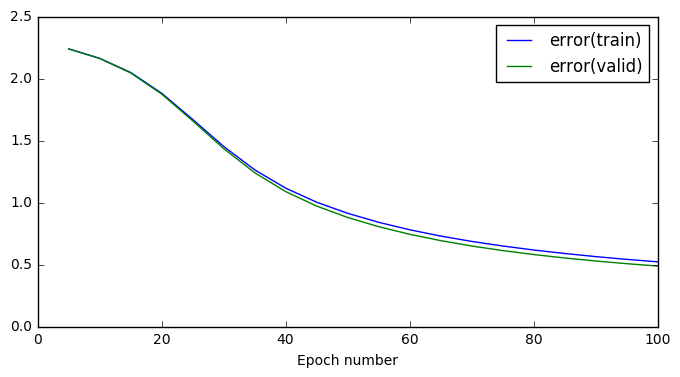

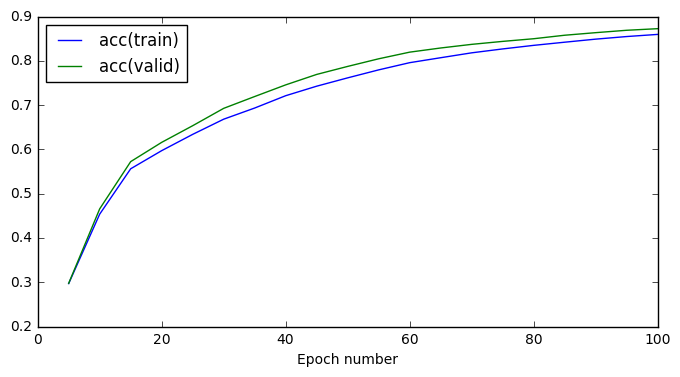

In [26]:
model, error = resetting()

learningRate = 1e-3
momCoeff=0.1
#r = 10
#learning_rate=, mom_coeff=0.9

#this is only the initial learning rate, the scheduler updates the learning rate within the loop
learning_rule = MomentumLearningRule(learning_rate=learningRate, mom_coeff=momCoeff)

#stats, keys, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
stats, keys, fig_1, ax_1, fig_2, ax_2, runTime = train_model_and_plot_stats(
    model, error, 
    learning_rule,
    train_data, valid_data, num_epochs, stats_interval,
    schedulers = [ConstantLearningRateScheduler(learning_rate=learningRate)]
)

fig_1.savefig('momentum1_lr_1e-3_momcoeff_0.1.svg')
fig_2.savefig('momentum2_lr_1e-3_momcoeff_0.1.svg')

getFinalValues(stats)

In this experiment the momentum is very small, insignificant to make a real difference and therefore the weights are let to follow their path without any “guidance”. This in combination with the initially small learning rate 0.001 give in a slow learning. We have start from a very low accuracy and after 100 epochs we reached at a testing accuracy of 87.3% which is worse than our previous experiments.

### Mom Coefficient 0.5

Epoch 5: 1.26s to complete
    error(train)=2.21e+00, acc(train)=3.77e-01, error(valid)=2.20e+00, acc(valid)=3.87e-01
Epoch 10: 1.26s to complete
    error(train)=2.03e+00, acc(train)=5.65e-01, error(valid)=2.02e+00, acc(valid)=5.89e-01
Epoch 15: 1.26s to complete
    error(train)=1.68e+00, acc(train)=6.77e-01, error(valid)=1.67e+00, acc(valid)=7.03e-01
Epoch 20: 1.26s to complete
    error(train)=1.28e+00, acc(train)=7.47e-01, error(valid)=1.26e+00, acc(valid)=7.71e-01
Epoch 25: 1.28s to complete
    error(train)=1.01e+00, acc(train)=7.90e-01, error(valid)=9.75e-01, acc(valid)=8.12e-01
Epoch 30: 1.36s to complete
    error(train)=8.29e-01, acc(train)=8.13e-01, error(valid)=7.93e-01, acc(valid)=8.37e-01
Epoch 35: 1.42s to complete
    error(train)=7.13e-01, acc(train)=8.29e-01, error(valid)=6.75e-01, acc(valid)=8.48e-01
Epoch 40: 1.26s to complete
    error(train)=6.33e-01, acc(train)=8.42e-01, error(valid)=5.95e-01, acc(valid)=8.59e-01
Epoch 45: 2.36s to complete
    error(train)=5.75

{'finalTestingAccuracy': 0.90579999999999894,
 'finalTestingError': 0.3368219222862186,
 'finalTrainingAccuracy': 0.89905999999999986,
 'finalTrainingError': 0.36276906868040998}

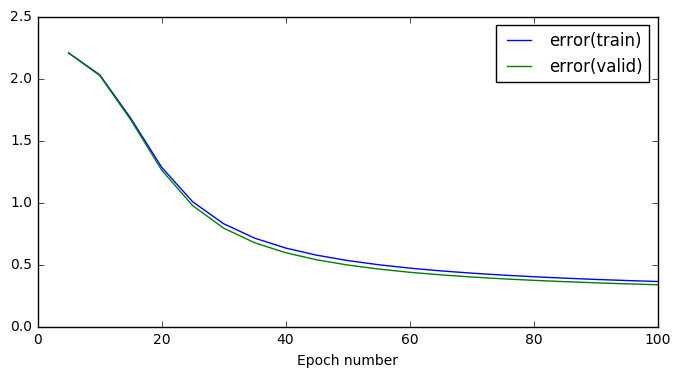

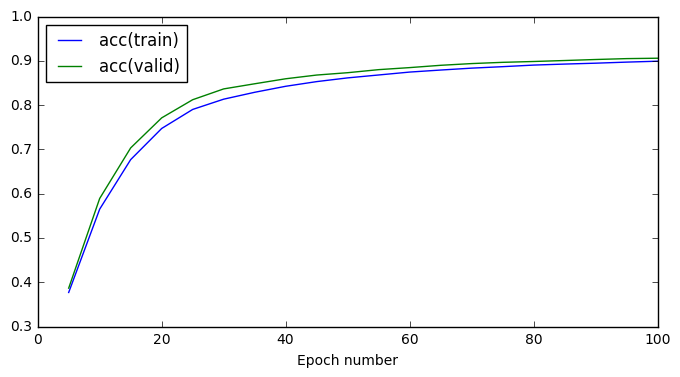

In [27]:
model, error = resetting()

learningRate = 1e-3
momCoeff=0.5
#r = 10
#learning_rate=, mom_coeff=0.9

#this is only the initial learning rate, the scheduler updates the learning rate within the loop
learning_rule = MomentumLearningRule(learning_rate=learningRate, mom_coeff=momCoeff)

#stats, keys, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
stats, keys, fig_1, ax_1, fig_2, ax_2, runTime = train_model_and_plot_stats(
    model, error, 
    learning_rule,
    train_data, valid_data, num_epochs, stats_interval,
    #schedulers = [ReciprocalLearningRateScheduler(learning_rate=learningRate, r = r)]
    schedulers = [ConstantLearningRateScheduler(learning_rate=learningRate)]
)

fig_1.savefig('momentum1_lr_1e-3_momcoeff_0.5.svg')
fig_2.savefig('momentum2_lr_1e-3_momcoeff_0.5.svg')

getFinalValues(stats)

In this expirement we see that even though the learning rate is the same the momentum has done a better job of “guiding” the weights towards the right direction avoiding local minimas. The overall final error is better and the accuracy has increased from 87.3% of the previous experiment to 90.6%
Can we do better? Let’s try larger momentum coefficient.

### Mom Coefficient 0.9

Epoch 5: 1.26s to complete
    error(train)=1.11e+00, acc(train)=7.54e-01, error(valid)=1.08e+00, acc(valid)=7.82e-01
Epoch 10: 1.27s to complete
    error(train)=5.53e-01, acc(train)=8.59e-01, error(valid)=5.15e-01, acc(valid)=8.74e-01
Epoch 15: 1.26s to complete
    error(train)=4.20e-01, acc(train)=8.86e-01, error(valid)=3.89e-01, acc(valid)=8.99e-01
Epoch 20: 1.26s to complete
    error(train)=3.65e-01, acc(train)=8.98e-01, error(valid)=3.38e-01, acc(valid)=9.07e-01
Epoch 25: 1.25s to complete
    error(train)=3.34e-01, acc(train)=9.05e-01, error(valid)=3.10e-01, acc(valid)=9.11e-01
Epoch 30: 1.25s to complete
    error(train)=3.12e-01, acc(train)=9.10e-01, error(valid)=2.91e-01, acc(valid)=9.14e-01
Epoch 35: 1.25s to complete
    error(train)=2.94e-01, acc(train)=9.15e-01, error(valid)=2.74e-01, acc(valid)=9.20e-01
Epoch 40: 1.33s to complete
    error(train)=2.78e-01, acc(train)=9.19e-01, error(valid)=2.60e-01, acc(valid)=9.25e-01
Epoch 45: 1.34s to complete
    error(train)=2.65

{'finalTestingAccuracy': 0.95589999999999875,
 'finalTestingError': 0.16614428154221297,
 'finalTrainingAccuracy': 0.95174000000000791,
 'finalTrainingError': 0.16668023921162292}

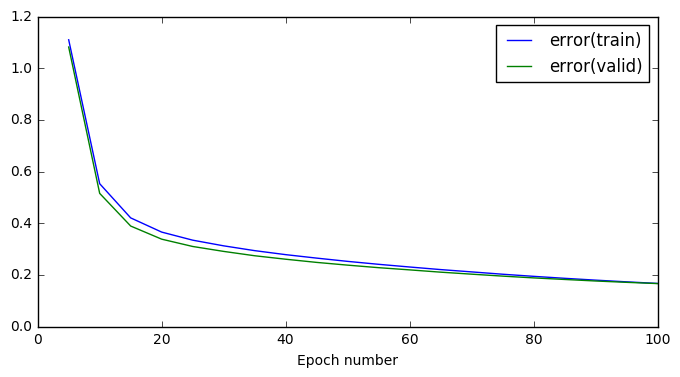

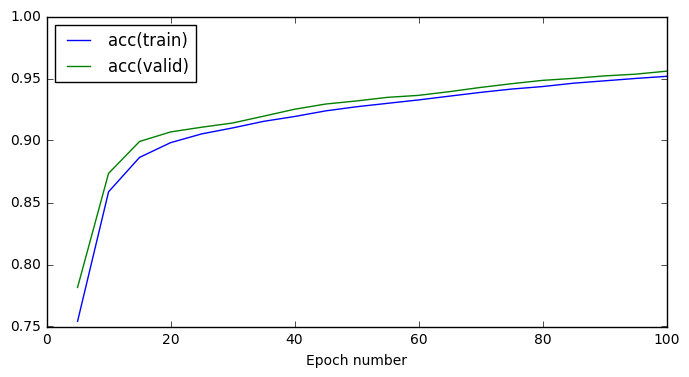

In [28]:
model, error = resetting()

learningRate = 1e-3
momCoeff=0.9
#r = 10

#this is only the initial learning rate, the scheduler updates the learning rate within the loop
learning_rule = MomentumLearningRule(learning_rate=learningRate, mom_coeff=momCoeff)

#stats, keys, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
stats, keys, fig_1, ax_1, fig_2, ax_2, runTime = train_model_and_plot_stats(
    model, error, 
    learning_rule,
    train_data, valid_data, num_epochs, stats_interval,
    schedulers = [ConstantLearningRateScheduler(learning_rate=learningRate)]
)

fig_1.savefig('momentum1_lr_1e-3_momcoeff_0.9.svg')
fig_2.savefig('momentum2_lr_1e-3_momcoeff_0.9.svg')

getFinalValues(stats)

So the conclusion is that the higher the coefficient the faster is the convergence for small learning rates. For mom coefficients of 0.5 and 0.1 we see that 100 epochs are not enough for convergence

It is expected that at the beginning the step we are going to make is quite large and therefore the weights will have a potentionally wrong direction.

If we do not do anything to manage that then we might go back and forth until we are at the right direction. And this is visible when lower mom coefficients are used.

However if we are unlucky enough and the initial conditions that we found ourselves in the wrong direction then at the beginning we do not want to use the momentum coefficient to make multiple successive steps in a similar direction in parameter space. Instead we want to allow the weights to move more freely.

I think of it like when you are driving and you want to make a sudden 180 degrees turn, then you do not want the ESP to kick in at first, but rather make an abrunt turn and then try to maneuver and bring the car in a straight line. (Given that you are maximizing for going to right direction and not for safety).

When training with momentum we can overcome the shallow local minima. Once again the analogy with a car on a road that has frequent turns left and right could be just faster if you go offroad and drive in a straight line neglecting the local minima.

### Variable Momentum over the epoch

In [14]:
from mlp.schedulers import MomentumCoefficientScheduler

In [26]:
def plotMomentum(a_asymptoticMomentumCoefficient, gamma, taf):
    fig = plt.figure()
    assert a_asymptoticMomentumCoefficient >=0 and a_asymptoticMomentumCoefficient <= 1
    assert gamma >= 0 and gamma <= taf
    assert taf >= 1

    epoch = np.arange(0, 100)
    momVar = a_asymptoticMomentumCoefficient * (1 - gamma/(epoch + taf))

    plt.plot(epoch, momVar)
    plt.ylabel('momentum coefficient')
    plt.xlabel('epochs')
    plt.show()
    return fig

### Very steepy curve case where the momentum rises very quickly

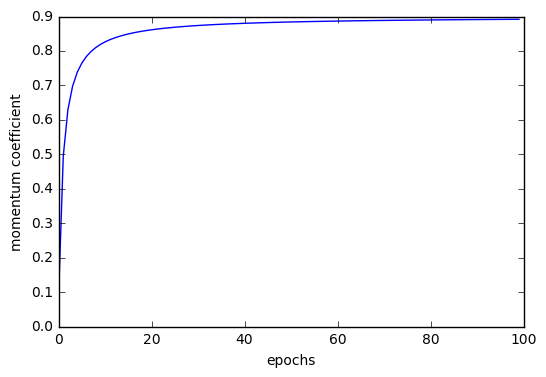

In [27]:
#let's see how to have some taf and gamma that make sense
a_asymptoticMomentumCoefficient = 0.9
gamma = 0.9
taf = 1

fig = plotMomentum(a_asymptoticMomentumCoefficient = a_asymptoticMomentumCoefficient,
             gamma = gamma,
             taf = taf)

fig.savefig("variableMomentumFunction_a_0.9_gamma_0.9_taf_1.svg")

Epoch 5: 1.30s to complete
    error(train)=2.16e+00, acc(train)=4.24e-01, error(valid)=2.16e+00, acc(valid)=4.30e-01
Epoch 10: 1.24s to complete
    error(train)=1.37e+00, acc(train)=7.05e-01, error(valid)=1.36e+00, acc(valid)=7.29e-01
Epoch 15: 1.24s to complete
    error(train)=7.46e-01, acc(train)=8.12e-01, error(valid)=7.11e-01, acc(valid)=8.35e-01
Epoch 20: 1.64s to complete
    error(train)=5.35e-01, acc(train)=8.57e-01, error(valid)=5.03e-01, acc(valid)=8.71e-01
Epoch 25: 1.41s to complete
    error(train)=4.41e-01, acc(train)=8.80e-01, error(valid)=4.13e-01, acc(valid)=8.89e-01
Epoch 30: 1.26s to complete
    error(train)=3.88e-01, acc(train)=8.94e-01, error(valid)=3.63e-01, acc(valid)=9.01e-01
Epoch 35: 1.28s to complete
    error(train)=3.54e-01, acc(train)=9.02e-01, error(valid)=3.32e-01, acc(valid)=9.07e-01
Epoch 40: 1.32s to complete
    error(train)=3.31e-01, acc(train)=9.07e-01, error(valid)=3.10e-01, acc(valid)=9.13e-01
Epoch 45: 1.61s to complete
    error(train)=3.12

{'finalTestingAccuracy': 0.94759999999999867,
 'finalTestingError': 0.19137661910746073,
 'finalTrainingAccuracy': 0.94292000000000586,
 'finalTrainingError': 0.19689110154882414}

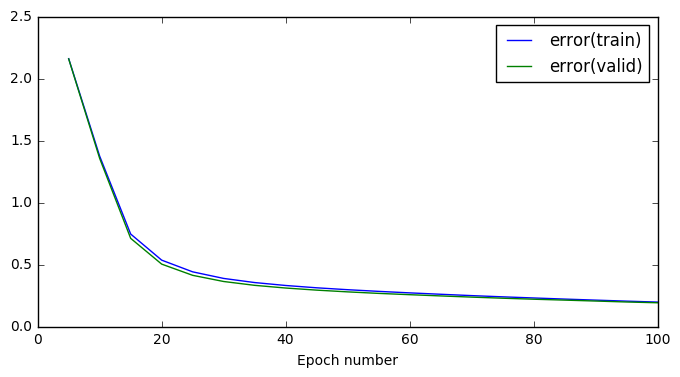

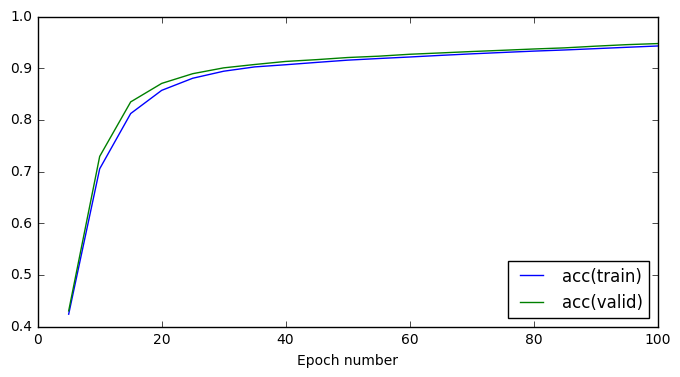

In [34]:
model, error = resetting()

learningRate = 1e-3
momCoeff=0

#this is only the initial mom coefficient, the scheduler updates the learning rate within the loop
learning_rule = MomentumLearningRule(learning_rate=learningRate, mom_coeff=momCoeff)

stats, keys, fig_1, ax_1, fig_2, ax_2, runTime = train_model_and_plot_stats(
    model, error, 
    learning_rule,
    train_data, valid_data, num_epochs, stats_interval,
    schedulers = [MomentumCoefficientScheduler(a_asymptoticMomentumCoefficient=a_asymptoticMomentumCoefficient,
                                              gamma=gamma,
                                              taf = taf)]
)

fig_1.savefig('varMomentum1_lr_1e-3_coeff_0.9_gamma_0.9_taf_1.svg')
fig_2.savefig('varMomentum2_lr_1e-3_coeff_0.9_gamma_0.9_taf_1.svg')

getFinalValues(stats)

We see that when the momentum plays little role at the beginning but very quickly becomes large that we have a very fast convergence at the beginning.

So if we want an enough good accuracy then we can use this method and around 20 epochs we have reached close to the desired accuracy.

However because the momentum has become too large too soon the converge is not very fast afterwards and therefore after 100 epochs we have not reached at the highest maximum accuracy. The drift is too large to allow the model to reach its best place.

### gamma = 0.9 and taf = 10

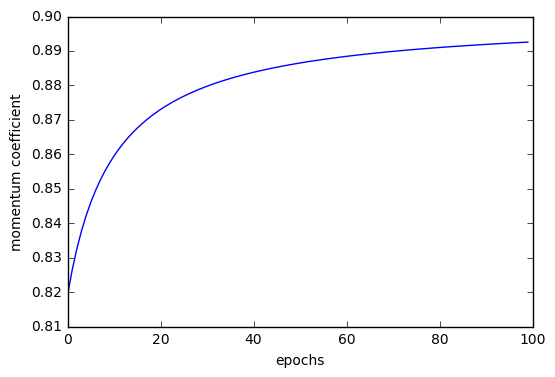

In [30]:
#let's see how to have some taf and gamma that make sense
a_asymptoticMomentumCoefficient = 0.9
gamma = 0.9
taf = 10

fig = plotMomentum(a_asymptoticMomentumCoefficient = a_asymptoticMomentumCoefficient,
             gamma = gamma,
             taf = taf)

fig.savefig('variableMomentumFunction_a_0.9_gamma_0.9_taf_10.svg')

Epoch 5: 1.24s to complete
    error(train)=1.69e+00, acc(train)=5.96e-01, error(valid)=1.68e+00, acc(valid)=6.15e-01
Epoch 10: 1.30s to complete
    error(train)=8.38e-01, acc(train)=7.85e-01, error(valid)=8.03e-01, acc(valid)=8.09e-01
Epoch 15: 1.24s to complete
    error(train)=5.57e-01, acc(train)=8.53e-01, error(valid)=5.21e-01, acc(valid)=8.68e-01
Epoch 20: 1.46s to complete
    error(train)=4.44e-01, acc(train)=8.82e-01, error(valid)=4.12e-01, acc(valid)=8.92e-01
Epoch 25: 2.01s to complete
    error(train)=3.86e-01, acc(train)=8.95e-01, error(valid)=3.58e-01, acc(valid)=9.03e-01
Epoch 30: 1.31s to complete
    error(train)=3.51e-01, acc(train)=9.03e-01, error(valid)=3.26e-01, acc(valid)=9.08e-01
Epoch 35: 1.32s to complete
    error(train)=3.27e-01, acc(train)=9.08e-01, error(valid)=3.05e-01, acc(valid)=9.13e-01
Epoch 40: 1.32s to complete
    error(train)=3.08e-01, acc(train)=9.13e-01, error(valid)=2.88e-01, acc(valid)=9.17e-01
Epoch 45: 1.32s to complete
    error(train)=2.93

{'finalTestingAccuracy': 0.95069999999999955,
 'finalTestingError': 0.18099190751974423,
 'finalTrainingAccuracy': 0.94596000000000646,
 'finalTrainingError': 0.18564652630986889}

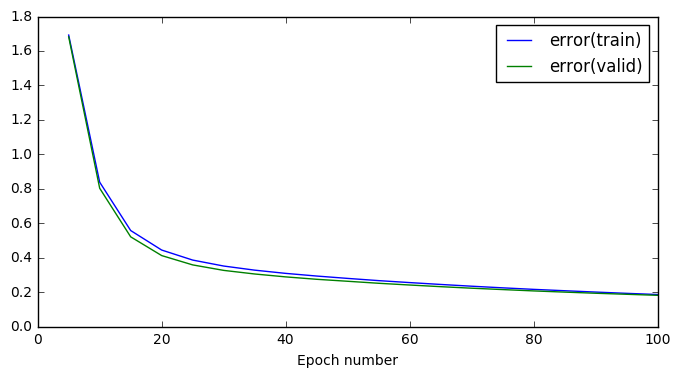

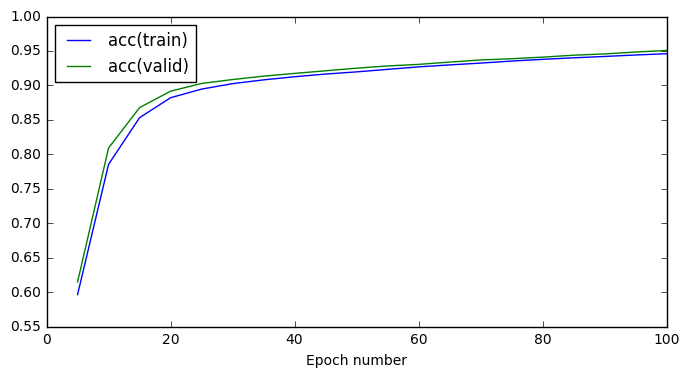

In [37]:
model, error = resetting()

learningRate = 1e-3
momCoeff=0 #here we start from a low mom coefficient, actually the lowest possible

#this is only the initial mom coefficient, the scheduler updates the learning rate within the loop
learning_rule = MomentumLearningRule(learning_rate=learningRate, mom_coeff=momCoeff)

stats, keys, fig_1, ax_1, fig_2, ax_2, runTime = train_model_and_plot_stats(
    model, error, 
    learning_rule,
    train_data, valid_data, num_epochs, stats_interval,
    schedulers = [MomentumCoefficientScheduler(a_asymptoticMomentumCoefficient=a_asymptoticMomentumCoefficient,
                                              gamma=gamma,
                                              taf = taf)]
)

fig_1.savefig('varMomentum1_lr_1e-3_coeff_0.9_gamma_0.9_taf_10.svg')
fig_2.savefig('varMomentum2_lr_1e-3_coeff_0.9_gamma_0.9_taf_10.svg')

getFinalValues(stats)

Here the momentum starts with a significant role but more slowly reaches to its asymptotic value.

Because the momentum starts with a significant value the accuracy is not very high at the beginning and the convergence is more slow.

The good news now is that because the drift is more slowly involved the updates at the weights are not severely affected from the momentum and therefore 100 epochs are enough for the model to converge to a higher accuracy than in the first case

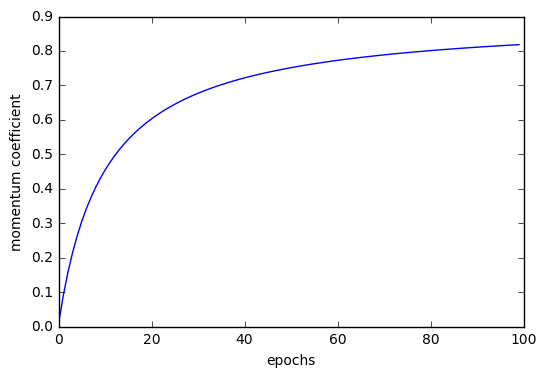

In [29]:
#let's see how to have some taf and gamma that make sense
a_asymptoticMomentumCoefficient = 0.9
gamma = 9.9
taf = 10

fig = plotMomentum(a_asymptoticMomentumCoefficient = a_asymptoticMomentumCoefficient,
             gamma = gamma,
             taf = taf)

fig.savefig('variableMomentumFunction_a_0.9_gamma_9.9_taf_10.svg')

Epoch 5: 4.28s to complete
    error(train)=2.23e+00, acc(train)=3.14e-01, error(valid)=2.23e+00, acc(valid)=3.12e-01
Epoch 10: 3.42s to complete
    error(train)=2.11e+00, acc(train)=5.03e-01, error(valid)=2.11e+00, acc(valid)=5.15e-01
Epoch 15: 3.62s to complete
    error(train)=1.82e+00, acc(train)=6.19e-01, error(valid)=1.82e+00, acc(valid)=6.40e-01
Epoch 20: 3.64s to complete
    error(train)=1.38e+00, acc(train)=6.76e-01, error(valid)=1.36e+00, acc(valid)=7.03e-01
Epoch 25: 3.65s to complete
    error(train)=1.03e+00, acc(train)=7.35e-01, error(valid)=9.97e-01, acc(valid)=7.61e-01
Epoch 30: 4.16s to complete
    error(train)=8.15e-01, acc(train)=7.85e-01, error(valid)=7.79e-01, acc(valid)=8.10e-01
Epoch 35: 4.09s to complete
    error(train)=6.75e-01, acc(train)=8.20e-01, error(valid)=6.39e-01, acc(valid)=8.39e-01
Epoch 40: 3.69s to complete
    error(train)=5.79e-01, acc(train)=8.45e-01, error(valid)=5.43e-01, acc(valid)=8.59e-01
Epoch 45: 3.40s to complete
    error(train)=5.09

{'finalTestingAccuracy': 0.92409999999999959,
 'finalTestingError': 0.26482750865848931,
 'finalTrainingAccuracy': 0.9184800000000013,
 'finalTrainingError': 0.28226382636614838}

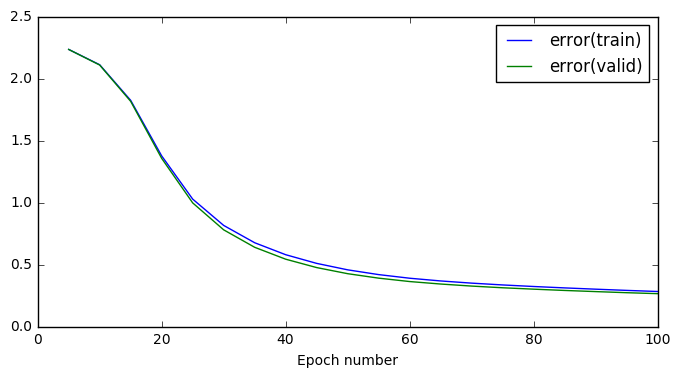

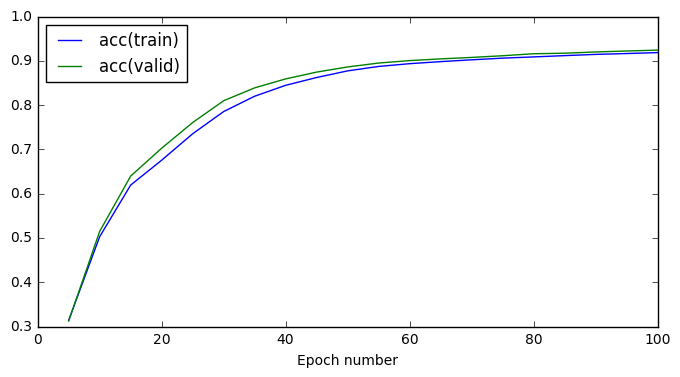

In [18]:
model, error = resetting()

learningRate = 1e-3
momCoeff=0 #here we start from a low mom coefficient, actually the lowest possible

#this is only the initial mom coefficient, the scheduler updates the learning rate within the loop
learning_rule = MomentumLearningRule(learning_rate=learningRate, mom_coeff=momCoeff)

stats, keys, fig_1, ax_1, fig_2, ax_2, runTime = train_model_and_plot_stats(
    model, error, 
    learning_rule,
    train_data, valid_data, num_epochs, stats_interval,
    schedulers = [MomentumCoefficientScheduler(a_asymptoticMomentumCoefficient=a_asymptoticMomentumCoefficient,
                                              gamma=gamma,
                                              taf = taf)]
)

fig_1.savefig('varMomentum1_lr_1e-3_coeff_0.9_gamma_9.9_taf_10.svg')
fig_2.savefig('varMomentum2_lr_1e-3_coeff_0.9_gamma_9.9_taf_10.svg')

getFinalValues(stats)

Here the change in the momentum is changing more slowly similarly to the second case but the main difference is that at first the momentum has a much lower value than in the second case.

So initially the momentum has a small value and therefore the drift is insignificant. So we could say that the weights are allowed to change at full speed.  
This is very good because generally we are going to start at a place away from the optimum and we would like to take large steps at the beginning.

However this experiment showed that changing the weights without any momentum at the beginning and with such a low learning rate it makes the entire process slower to converge. We have  done worse than the previous two experiments by reaching at only ~92.4% of final testing accuracy.

# Part 3: Adaptive learning rules

In [19]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider

# Seed a random number generator
seed = 10102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

In [20]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit

input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# we are using the resetting method defined above instead
# model = MultipleLayerModel([
#     AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
#     SigmoidLayer(),
#     AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
#     SigmoidLayer(),
#     AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
# ])

# error = CrossEntropySoftmaxError()

## AdaGrad

https://www.quora.com/What-is-the-purpose-of-AdaGrad-for-stochastic-gradient-decent-neural-network-training

Some features can be extremely useful and informative to an optimization problem but they may not show up in most of the training instances or data. If, when they do show up, they are weighted equally in terms of learning rate as a feature that has shown up hundreds of times we are practically saying that the influence of such features means nothing in the overall optimization (it's impact per step in the stochastic gradient descent will be so small that it can practically be discounted). To counter this, AdaGrad makes it such that features that are more sparse in the data have a higher learning rate which translates into a larger update for that feature (i.e. in logistic regression that feature's regression coefficient will be increased/decreased more than a coefficient of a feature that is seen very often).

Simply put, sparse features can be very useful. I don't have an example of application in neural network training. Different adaptive learning algorithms are useful with different data (it would really depend on what your data is and how much importance you place on sparse features). 

### AdaGrad with learning rate 1e-1

Epoch 5: 1.81s to complete
    error(train)=2.76e-02, acc(train)=9.93e-01, error(valid)=8.65e-02, acc(valid)=9.74e-01
Epoch 10: 1.83s to complete
    error(train)=1.00e-02, acc(train)=9.98e-01, error(valid)=8.97e-02, acc(valid)=9.76e-01
Epoch 15: 1.81s to complete
    error(train)=4.27e-03, acc(train)=1.00e+00, error(valid)=9.08e-02, acc(valid)=9.77e-01
Epoch 20: 1.78s to complete
    error(train)=2.27e-03, acc(train)=1.00e+00, error(valid)=9.58e-02, acc(valid)=9.77e-01
Epoch 25: 1.95s to complete
    error(train)=1.53e-03, acc(train)=1.00e+00, error(valid)=9.91e-02, acc(valid)=9.77e-01
Epoch 30: 2.36s to complete
    error(train)=1.11e-03, acc(train)=1.00e+00, error(valid)=1.02e-01, acc(valid)=9.78e-01
Epoch 35: 1.90s to complete
    error(train)=8.61e-04, acc(train)=1.00e+00, error(valid)=1.04e-01, acc(valid)=9.77e-01
Epoch 40: 1.92s to complete
    error(train)=6.90e-04, acc(train)=1.00e+00, error(valid)=1.06e-01, acc(valid)=9.78e-01
Epoch 45: 2.00s to complete
    error(train)=5.75

{'finalTestingAccuracy': 0.97799999999999909,
 'finalTestingError': 0.11826241268321168,
 'finalTrainingAccuracy': 1.0,
 'finalTrainingError': 0.00018470066656494193}

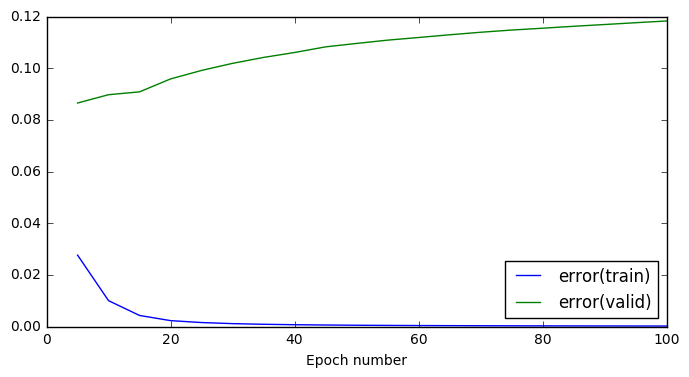

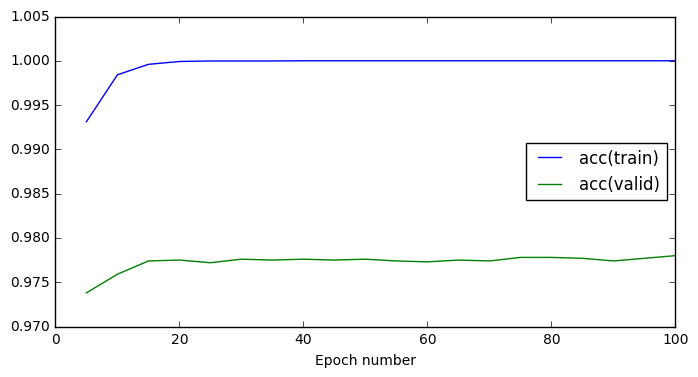

In [21]:
model, error = resetting()

learningRate = 1e-1

#this is only the initial mom coefficient, the scheduler updates the learning rate within the loop
learning_rule = AdaGradLearningRule(learning_rate=learningRate)

stats, keys, fig_1, ax_1, fig_2, ax_2, runTime = train_model_and_plot_stats(
    model, error, 
    learning_rule,
    train_data, valid_data, num_epochs, stats_interval,
    schedulers = [ConstantLearningRateScheduler(learningRate)]
)

fig_1.savefig('adaGrad1_lr_0.1.svg')
fig_2.savefig('adaGrad2_lr_0.1.svg')

getFinalValues(stats)

Within 15 epochs we have reached a very good accuracy performance ~97.8% on the validation set. However from the error curve of the validation set and from the fact that training accuracy has reached at 100% too quickly it is apparent that we have overfitted.

### AdaGrad with learning rate ten times smaller: 0.01

Epoch 5: 1.89s to complete
    error(train)=2.07e-01, acc(train)=9.39e-01, error(valid)=1.99e-01, acc(valid)=9.42e-01
Epoch 10: 1.95s to complete
    error(train)=1.65e-01, acc(train)=9.51e-01, error(valid)=1.66e-01, acc(valid)=9.54e-01
Epoch 15: 2.35s to complete
    error(train)=1.41e-01, acc(train)=9.59e-01, error(valid)=1.46e-01, acc(valid)=9.59e-01
Epoch 20: 2.02s to complete
    error(train)=1.25e-01, acc(train)=9.64e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01
Epoch 25: 1.95s to complete
    error(train)=1.13e-01, acc(train)=9.68e-01, error(valid)=1.26e-01, acc(valid)=9.64e-01
Epoch 30: 1.86s to complete
    error(train)=1.03e-01, acc(train)=9.71e-01, error(valid)=1.20e-01, acc(valid)=9.65e-01
Epoch 35: 1.87s to complete
    error(train)=9.52e-02, acc(train)=9.73e-01, error(valid)=1.15e-01, acc(valid)=9.67e-01
Epoch 40: 1.95s to complete
    error(train)=8.86e-02, acc(train)=9.75e-01, error(valid)=1.11e-01, acc(valid)=9.67e-01
Epoch 45: 1.94s to complete
    error(train)=8.27

{'finalTestingAccuracy': 0.97359999999999924,
 'finalTestingError': 0.089304122830480934,
 'finalTrainingAccuracy': 0.98798000000000552,
 'finalTrainingError': 0.047878933891372183}

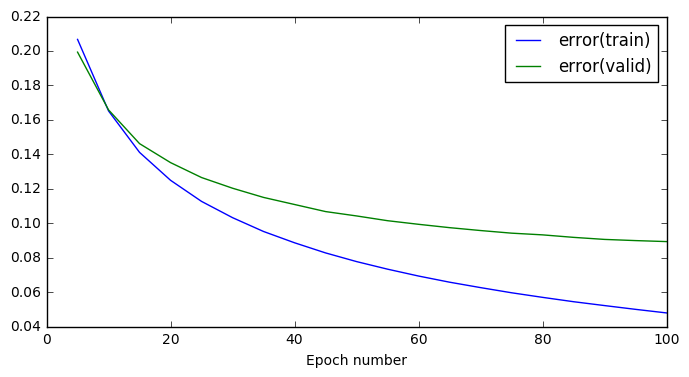

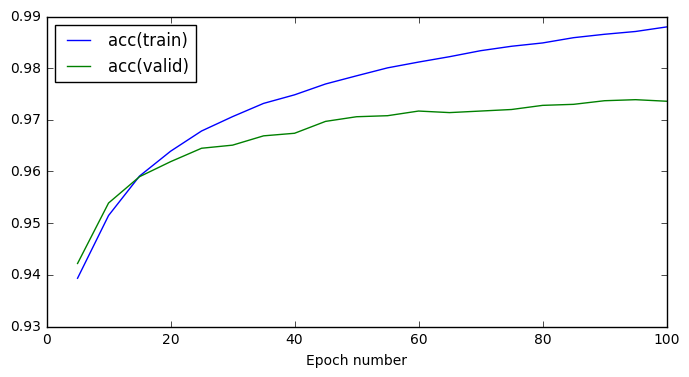

In [23]:
model, error = resetting()

learningRate = 0.01

#this is only the initial mom coefficient, the scheduler updates the learning rate within the loop
learning_rule = AdaGradLearningRule(learning_rate=learningRate)

stats, keys, fig_1, ax_1, fig_2, ax_2, runTime = train_model_and_plot_stats(
    model, error, 
    learning_rule,
    train_data, valid_data, num_epochs, stats_interval,
    schedulers = [ConstantLearningRateScheduler(learningRate)]
)

fig_1.savefig('adaGrad1_lr_0.01.svg')
fig_2.savefig('adaGrad2_lr_0.01.svg')

getFinalValues(stats)

Here we have not overfitted which is good. On the other hand the learning has progressed a little bit more slowly to finally reach at a final testing accuracy of 97.3%

### AdaGrad with learning rate five times smaller: 0.02

Epoch 5: 2.05s to complete
    error(train)=1.30e-01, acc(train)=9.62e-01, error(valid)=1.38e-01, acc(valid)=9.62e-01
Epoch 10: 2.29s to complete
    error(train)=9.30e-02, acc(train)=9.75e-01, error(valid)=1.12e-01, acc(valid)=9.68e-01
Epoch 15: 1.81s to complete
    error(train)=7.39e-02, acc(train)=9.80e-01, error(valid)=1.00e-01, acc(valid)=9.71e-01
Epoch 20: 1.79s to complete
    error(train)=6.14e-02, acc(train)=9.84e-01, error(valid)=9.42e-02, acc(valid)=9.71e-01
Epoch 25: 1.93s to complete
    error(train)=5.21e-02, acc(train)=9.87e-01, error(valid)=8.88e-02, acc(valid)=9.73e-01
Epoch 30: 1.86s to complete
    error(train)=4.50e-02, acc(train)=9.89e-01, error(valid)=8.58e-02, acc(valid)=9.74e-01
Epoch 35: 1.78s to complete
    error(train)=3.93e-02, acc(train)=9.91e-01, error(valid)=8.38e-02, acc(valid)=9.75e-01
Epoch 40: 1.83s to complete
    error(train)=3.47e-02, acc(train)=9.92e-01, error(valid)=8.23e-02, acc(valid)=9.75e-01
Epoch 45: 2.16s to complete
    error(train)=3.07

TypeError: cannot concatenate 'str' and 'float' objects

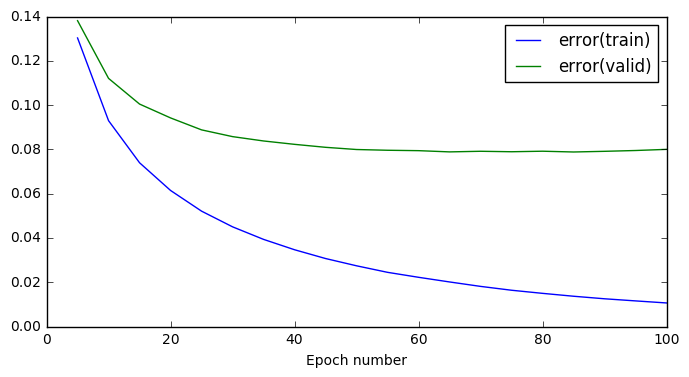

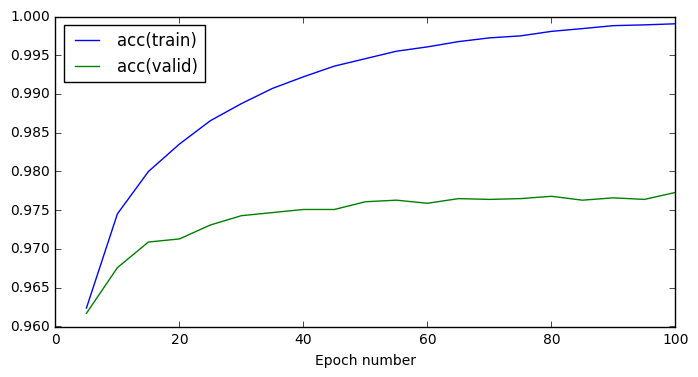

In [24]:
model, error = resetting()

learningRate = 0.02

#this is only the initial mom coefficient, the scheduler updates the learning rate within the loop
learning_rule = AdaGradLearningRule(learning_rate=learningRate)

stats, keys, fig_1, ax_1, fig_2, ax_2, runTime = train_model_and_plot_stats(
    model, error, 
    learning_rule,
    train_data, valid_data, num_epochs, stats_interval,
    schedulers = [ConstantLearningRateScheduler(learningRate)]
)

fig_1.savefig('adaGrad1_lr_' + str(learningRate) + '.svg')
fig_2.savefig('adaGrad2_lr_' + str(learningRate + '.svg')

getFinalValues(stats)

In [25]:
fig_1.savefig('adaGrad1_lr_' + str(learningRate) + '.svg')
fig_2.savefig('adaGrad2_lr_' + str(learningRate) + '.svg')

getFinalValues(stats)

{'finalTestingAccuracy': 0.97729999999999917,
 'finalTestingError': 0.079997812108674252,
 'finalTrainingAccuracy': 0.99906000000000061,
 'finalTrainingError': 0.010632486694816316}

At this last AdaGrad experiment the performance is better than the previous one. Again we do not overfit which is a good thing. Secondly the accuracy curve is very steep at the beginning which is an even better thing. We have reached ~97% at 20 epochs while at the previous experiment we were only at 96% the first 20 epochs and we needed more than 80 epochs to reach 97%.

Overall it seems that AdaGrad is not doing a superbly better job on the MNIST problem because the MNIST problem is already balanced. It has equal number of instances for each letter which makes it easy for less complicated algorithm to converge quickly and reach high testing accuracies.

## RmsProp

https://www.quora.com/What-is-an-intuitive-explanation-of-RMSProp

Basically, SGD has a problem in that learning rates have to scale with 1/T to get convergence, where T is the iteration number (ie: after a while you take really small steps and don’t get a lot of progress).

RMSProp and other methods try to get around this by automatically adjusting the step size so that the step is on the same scale as the gradients - as the average gradient gets smaller, the coefficient in the SGD update gets bigger to compensate.

http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf

### RmsProp with learning rate = 1e-3 and beta = 0.9

Epoch 5: 2.27s to complete
    error(train)=9.91e-02, acc(train)=9.71e-01, error(valid)=1.17e-01, acc(valid)=9.66e-01
Epoch 10: 1.99s to complete
    error(train)=4.78e-02, acc(train)=9.86e-01, error(valid)=8.70e-02, acc(valid)=9.76e-01
Epoch 15: 2.23s to complete
    error(train)=2.84e-02, acc(train)=9.92e-01, error(valid)=8.93e-02, acc(valid)=9.76e-01
Epoch 20: 2.22s to complete
    error(train)=1.64e-02, acc(train)=9.96e-01, error(valid)=9.19e-02, acc(valid)=9.78e-01
Epoch 25: 2.32s to complete
    error(train)=9.49e-03, acc(train)=9.98e-01, error(valid)=1.01e-01, acc(valid)=9.76e-01
Epoch 30: 2.41s to complete
    error(train)=5.19e-03, acc(train)=9.99e-01, error(valid)=1.06e-01, acc(valid)=9.77e-01
Epoch 35: 2.05s to complete
    error(train)=4.07e-03, acc(train)=9.99e-01, error(valid)=1.26e-01, acc(valid)=9.76e-01
Epoch 40: 2.04s to complete
    error(train)=2.33e-03, acc(train)=9.99e-01, error(valid)=1.45e-01, acc(valid)=9.74e-01
Epoch 45: 4.30s to complete
    error(train)=9.24

{'finalTestingAccuracy': 0.97439999999999927,
 'finalTestingError': 0.33179253819312676,
 'finalTrainingAccuracy': 1.0,
 'finalTrainingError': 2.3751641249253207e-08}

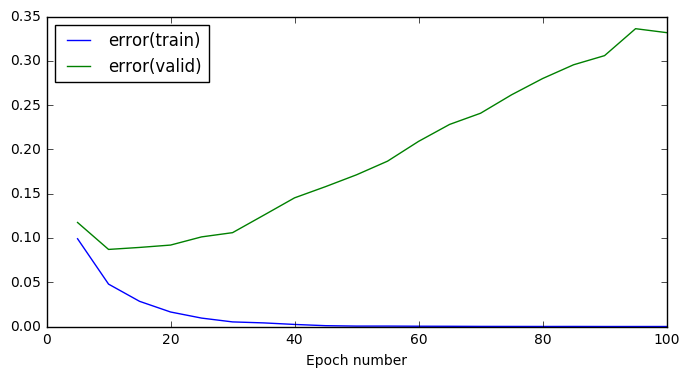

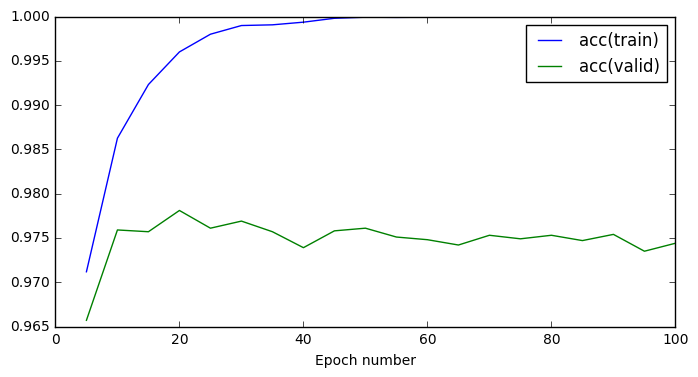

In [26]:
model, error = resetting()

learningRate = 1e-3
beta = 0.9

learning_rule = RmsPropLearningRule(learning_rate=learningRate, beta=beta)

stats, keys, fig_1, ax_1, fig_2, ax_2, runTime = train_model_and_plot_stats(
    model, error, 
    learning_rule,
    train_data, valid_data, num_epochs, stats_interval,
    schedulers = [ConstantLearningRateScheduler(learningRate)]
)

fig_1.savefig('rmsProp1_lr_1e-3_beta_0.9.svg')
fig_2.savefig('rmsProp2_lr_1e-3_beta_0.9.svg')

getFinalValues(stats)

In this experiment we have overfitted because we have reached almost zero error and perfect accuracy on the training at ~40 epochs. We also notice that the validation error is constantly increasing. The final testing accuracy is not so bad at around 97.4%.

### RmsProp with learning rate = 1e-3 and beta = 0.5

Epoch 5: 2.24s to complete
    error(train)=1.31e-01, acc(train)=9.61e-01, error(valid)=1.41e-01, acc(valid)=9.61e-01
Epoch 10: 1.94s to complete
    error(train)=8.62e-02, acc(train)=9.75e-01, error(valid)=1.14e-01, acc(valid)=9.69e-01
Epoch 15: 2.03s to complete
    error(train)=6.93e-02, acc(train)=9.81e-01, error(valid)=1.12e-01, acc(valid)=9.70e-01
Epoch 20: 2.02s to complete
    error(train)=5.88e-02, acc(train)=9.84e-01, error(valid)=1.15e-01, acc(valid)=9.71e-01
Epoch 25: 1.95s to complete
    error(train)=5.26e-02, acc(train)=9.87e-01, error(valid)=1.25e-01, acc(valid)=9.71e-01
Epoch 30: 2.07s to complete
    error(train)=4.63e-02, acc(train)=9.88e-01, error(valid)=1.26e-01, acc(valid)=9.71e-01
Epoch 35: 2.62s to complete
    error(train)=3.95e-02, acc(train)=9.90e-01, error(valid)=1.28e-01, acc(valid)=9.72e-01
Epoch 40: 2.71s to complete
    error(train)=3.76e-02, acc(train)=9.91e-01, error(valid)=1.35e-01, acc(valid)=9.74e-01
Epoch 45: 1.97s to complete
    error(train)=3.77

{'finalTestingAccuracy': 0.96669999999999889,
 'finalTestingError': 0.25848082591615268,
 'finalTrainingAccuracy': 0.99696000000000162,
 'finalTrainingError': 0.016937242765385364}

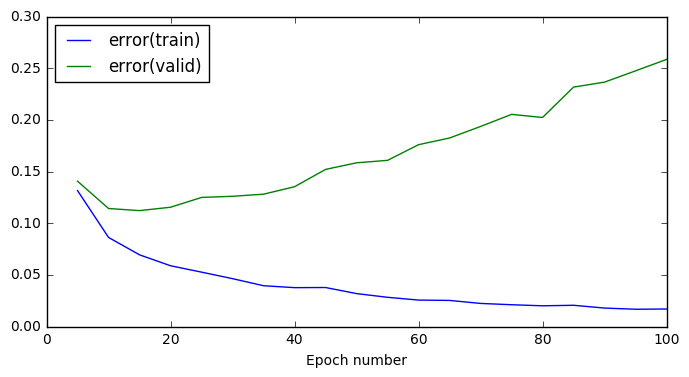

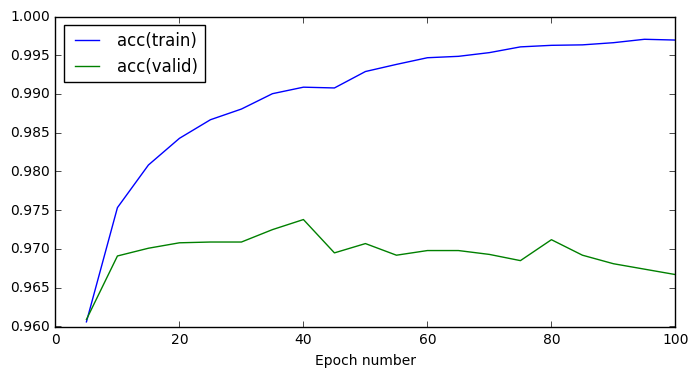

In [27]:
model, error = resetting()

learningRate = 1e-3
beta = 0.5

learning_rule = RmsPropLearningRule(learning_rate=learningRate, beta=beta)

stats, keys, fig_1, ax_1, fig_2, ax_2, runTime = train_model_and_plot_stats(
    model, error, 
    learning_rule,
    train_data, valid_data, num_epochs, stats_interval,
    schedulers = [ConstantLearningRateScheduler(learningRate)]
)

fig_1.savefig('rmsProp1_lr_1e-3_beta_0.5.svg')
fig_2.savefig('rmsProp2_lr_1e-3_beta_0.5.svg')

getFinalValues(stats)

Lowering the beta parameter did not help much because it made the learning rate to be too slow too soon. A similar problem we encountered when ran the AdaGrad experiments.
So in this case we have no issues of overfitting but the final accuracy is lower than that of the previous experiment to 96.7%.

Epoch 5: 2.36s to complete
    error(train)=3.44e-01, acc(train)=9.04e-01, error(valid)=3.13e-01, acc(valid)=9.14e-01
Epoch 10: 2.21s to complete
    error(train)=2.53e-01, acc(train)=9.26e-01, error(valid)=2.32e-01, acc(valid)=9.33e-01
Epoch 15: 2.00s to complete
    error(train)=2.08e-01, acc(train)=9.38e-01, error(valid)=1.96e-01, acc(valid)=9.43e-01
Epoch 20: 1.96s to complete
    error(train)=1.78e-01, acc(train)=9.47e-01, error(valid)=1.71e-01, acc(valid)=9.51e-01
Epoch 25: 2.13s to complete
    error(train)=1.54e-01, acc(train)=9.55e-01, error(valid)=1.54e-01, acc(valid)=9.55e-01
Epoch 30: 2.04s to complete
    error(train)=1.35e-01, acc(train)=9.60e-01, error(valid)=1.39e-01, acc(valid)=9.60e-01
Epoch 35: 2.27s to complete
    error(train)=1.19e-01, acc(train)=9.66e-01, error(valid)=1.28e-01, acc(valid)=9.62e-01
Epoch 40: 2.15s to complete
    error(train)=1.06e-01, acc(train)=9.69e-01, error(valid)=1.19e-01, acc(valid)=9.64e-01
Epoch 45: 1.99s to complete
    error(train)=9.52

{'finalTestingAccuracy': 0.97419999999999907,
 'finalTestingError': 0.088663164707988434,
 'finalTrainingAccuracy': 0.9893000000000054,
 'finalTrainingError': 0.039623922250447564}

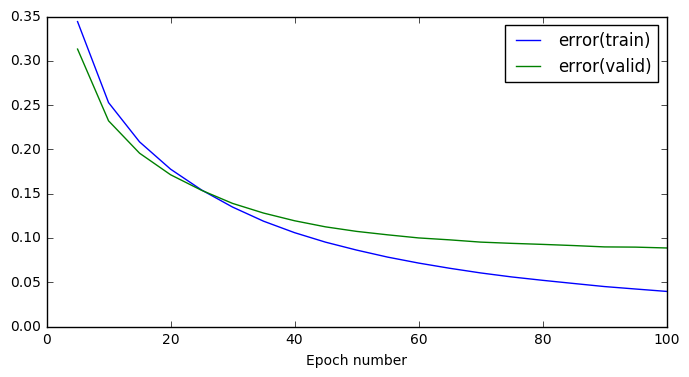

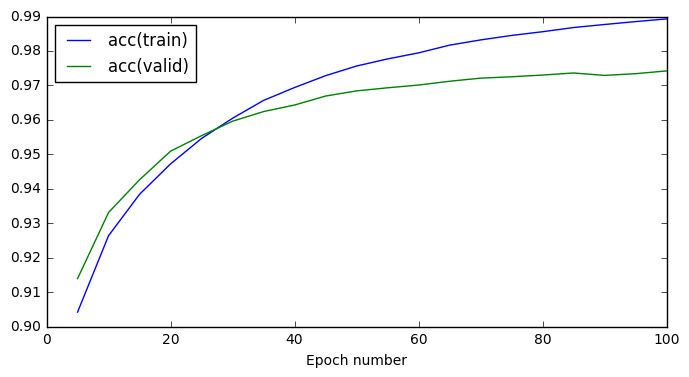

In [28]:
model, error = resetting()

learningRate = 1e-4
beta = 0.9

#this is only the initial mom coefficient, the scheduler updates the learning rate within the loop
learning_rule = RmsPropLearningRule(learning_rate=learningRate, beta=beta)

stats, keys, fig_1, ax_1, fig_2, ax_2, runTime = train_model_and_plot_stats(
    model, error, 
    learning_rule,
    train_data, valid_data, num_epochs, stats_interval,
    schedulers = [ConstantLearningRateScheduler(learningRate)]
)

fig_1.savefig('rmsProp1_lr_' + str(learningRate) + '_beta_' + str(beta) + '.svg')
fig_2.savefig('rmsProp2_lr_' + str(learningRate) + '_beta_' + str(beta) + '.svg')

getFinalValues(stats)

In this experiment we used again the same beta coefficient for RmsProp equal to 0.9 which is the recommended one and we lowered the learning rate coefficient even further to 1e-4.
In this experiment we see how the learning rate becomes adaptable because with such low learning rate you would expect minimal or no learning progress with previous algorithms.
This is an advantage because we can do not have to calibrate the learning rate coefficient to a proper value each time but we want a roughly small enough one.
The final testing accuracy is at 97.4% with an error close to the training error.